# <font color='DarkBlue'>Keras tutorial

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

Using TensorFlow backend.


## <font color='IndianRed'>Emotion Tracking

To build and train this model, we have gathered pictures of some volunteers. The dataset is labeled 'Happy' or 'Not Happy'

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test  = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test  = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples     = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape : " + str(X_test.shape))
print ("Y_test shape : " + str(Y_test.shape))

number of training examples = 600
number of test examples     = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape : (150, 64, 64, 3)
Y_test shape : (150, 1)


## <font color='IndianRed'>Building a Keras model

Keras is very good for rapid prototyping. In just a short time you will be able to build a model that achieves outstanding results.

Here is an example of a model in Keras:

```python
def model(input_shape):
    """
    input_shape: The height, width and channels as a tuple.  
    
    Note that this does not include the 'batch' as a dimension.
    If you have a batch like 'X_train', 
    then you can provide the input_shape using
    X_train.shape[1:]
    """
    
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance.
    model = Model(inputs = X_input, outputs = X, name='MyModel')
    
    return model
```

#### Variable naming convention

* Keras uses a different convention with variable names than we've previously used with Numpy and TensorFlow. 
* Instead of creating unique variable names for each step and each layer, such as 
```
    X  = ...
    Z1 = ...
    A1 = ...
```
* Keras re-uses and overwrites the same variable at each step:
```
    X = ...
    X = ...
    X = ...
```
* The exception is `X_input`, which we kept separate since it's needed later.

#### Objects as functions
* Notice how there are two pairs of parentheses in each statement.  For example:
```
    X = ZeroPadding2D((3, 3))(X_input)
```
* The first is a constructor call which creates an object (ZeroPadding2D).

* In Python, objects can be called as functions. 
    Ref: [Python Pandemonium](https://medium.com/python-pandemonium/function-as-objects-in-python-d5215e6d1b0d).

* The single line is equivalent to this:
```
    ZP = ZeroPadding2D((3, 3)) # ZP is an object that can be called as a function
    X = ZP(X_input) 
```

**Exercise**: Implement a `HappyModel()`.  

In [3]:
def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]

    Returns:
    
    model -- a Model() instance in Keras
    """
    
    
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
        
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
        
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)
        
    # FLATTEN X
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
        
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    return model

You have now built a function to describe your model. To train and test this model, there are four steps in Keras:

   1. Create the model by calling the function above  

   2. Compile the model by `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`  

   3. Train the model by calling `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`  

   4. Test the model by calling `model.evaluate(x = ..., y = ...)`  

Ref: [Keras documentation](https://keras.io/models/model/)

#### Step 1: create the model.  
**Hint**:  
The `input_shape` parameter is a tuple (height, width, channels).  It excludes the batch number.  
Try `X_train.shape[1:]` as the `input_shape`.

In [4]:
print(X_train.shape[1:4])
happyModel = HappyModel(X_train.shape[1:4])

(64, 64, 3)


#### Step 2: compile the model

**Hint**:  
- Optimizers : `'adam'`, `'sgd'` or others.  
- Loss function : `'binary_cross_entropy'`.  

**Note**: `categorical_cross_entropy` won't work with your data set as its formatted, because the data is an array of 0 or 1 rather than two arrays (one for each category). Refer Documentation for [losses](https://keras.io/losses/)

In [5]:
happyModel.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

#### Step 3: train the model

**Hint**:  
Use the `X_train`, `Y_train` variables.  
Use integers for the epochs and batch_size
If you run `fit()` again, the `model` will continue to train with the parameters it has already learned instead of reinitializing them.

In [6]:
history = happyModel.fit(X_train, Y_train, epochs = 10, batch_size = 20, verbose = 1)

Epoch 1/10
600/600 [==============================] - 13s - loss: 0.6823 - acc: 0.7550    
Epoch 2/10
600/600 [==============================] - 13s - loss: 0.2164 - acc: 0.9100    
Epoch 3/10
600/600 [==============================] - 13s - loss: 0.2054 - acc: 0.9133    
Epoch 4/10
600/600 [==============================] - 13s - loss: 0.1705 - acc: 0.9383    
Epoch 5/10
600/600 [==============================] - 13s - loss: 0.2027 - acc: 0.9217    
Epoch 6/10
600/600 [==============================] - 13s - loss: 0.0969 - acc: 0.9700    
Epoch 7/10
600/600 [==============================] - 13s - loss: 0.0462 - acc: 0.9867    
Epoch 8/10
600/600 [==============================] - 13s - loss: 0.1164 - acc: 0.9617    
Epoch 9/10
600/600 [==============================] - 13s - loss: 0.0651 - acc: 0.9783    
Epoch 10/10
600/600 [==============================] - 13s - loss: 0.0414 - acc: 0.9883    


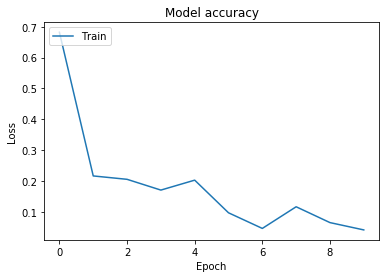

In [7]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

#### Step 4: evaluate model  
**Hint**:  
Use the `'X_test'` and `'Y_test'` variables to evaluate the model's performance.

In [8]:
preds = happyModel.evaluate(X_test, Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 1s     

Loss = 0.207065603336
Test Accuracy = 0.90666667064


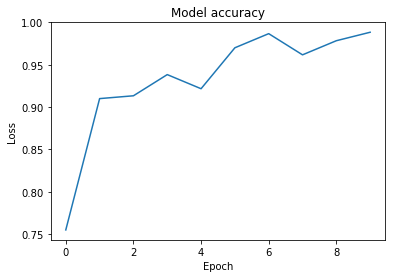

In [9]:
#plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Tips for improving your model

If you have not yet achieved a very good accuracy (>= 80%), here are some things tips:

- Use blocks of CONV->BATCHNORM->RELU such as:
```python
X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X)
X = BatchNormalization(axis = 3, name = 'bn0')(X)
X = Activation('relu')(X)
```
until your height and width dimensions are quite low and your number of channels quite large (≈32 for example).  
You can then flatten the volume and use a fully-connected layer.
- Use MAXPOOL after such blocks.  It will help you lower the dimension in height and width.
- Change your optimizer. We find `adam` works well. 
- If you get memory issues, lower your batch_size (e.g. 12 )
- Run more epochs until you see the train accuracy no longer improves. 

**Note**: If you perform hyperparameter tuning on your model, the test set actually becomes a dev set, and your model might end up overfitting to the test (dev) set. Normally, you'll want separate dev and test sets.  The dev set is used for parameter tuning, and the test set is used once to estimate the model's performance in production.

## <font color='IndianRed'>Useful functions in Keras

- `model.summary()`: prints the details of your layers in a table with the sizes of its inputs/outputs
- `plot_model()`: plots your graph in a nice layout. You can even save it as ".png" using SVG() if you'd like to share it on social media ;). It is saved in "File" then "Open..." in the upper bar of the notebook.

In [10]:
happyModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
__________

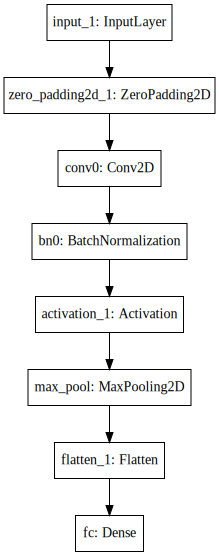

In [11]:
plot_model(happyModel, to_file='HappyModel.png')
SVG(model_to_dot(happyModel).create(prog='dot', format='svg'))

## <font color='IndianRed'>Test own image

[[ 0.]]


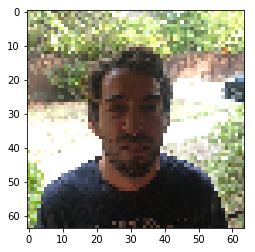

In [12]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happyModel.predict(x))